In [2]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

os.chdir(os.path.dirname(os.path.abspath('__file__')))

In [100]:
def best_arima(train, predict_n, d):
    p = q = range(1, 10)
    best_mape = 1
    best_p = best_q = 0
    for i in p:
        for j in q:
            model = ARIMA(order=(i, d, j))
            model_fit = model.fit(train)
            predictions = model_fit.predict(predict_n)
            mape = mean_absolute_percentage_error(test, predictions)
            if mape < best_mape:
                best_p = i
                best_q = j
                best_mape = mape
    print(best_p, best_q, best_mape)

In [101]:
# cargar los datos de la db
conn = sqlite3.connect('DB/daily_visits.db')
df = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date', index_col='Date')
conn.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851 entries, 2020-01-01 to 2022-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Users   851 non-null    int64
dtypes: int64(1)
memory usage: 13.3 KB


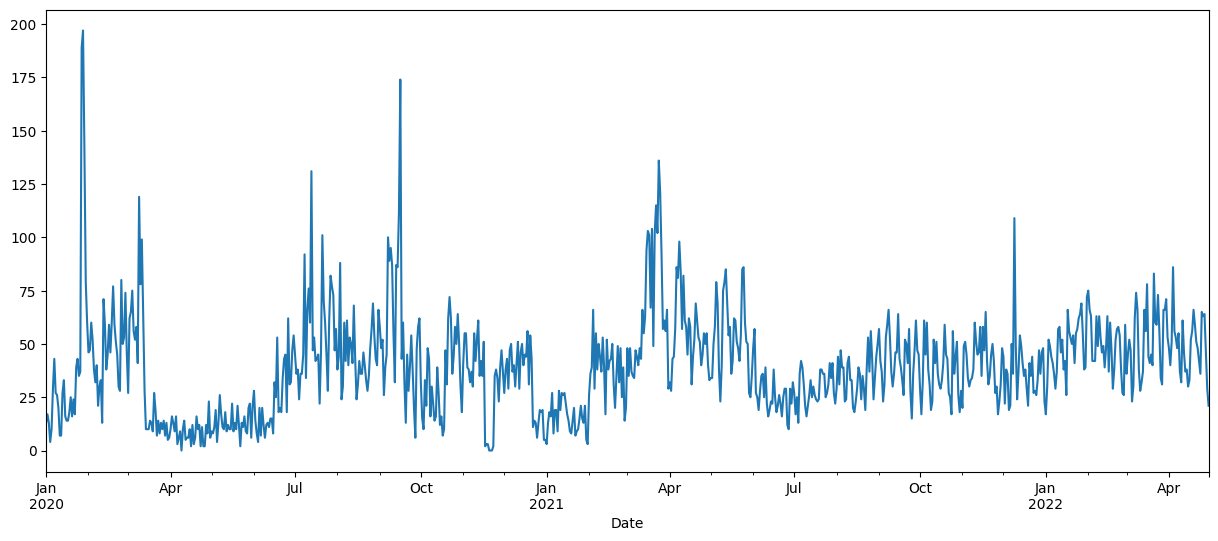

In [102]:
df['Users'].plot(figsize=(15,6));

In [104]:
# valores maximos
df[df['Users'].values > 100]

,Users
Date,
2020-01-27,189
2020-01-28,197
2020-01-29,142
2020-03-09,119
2020-07-13,131
2020-07-21,101
2020-09-15,112
2020-09-16,174
2021-03-16,103


In [105]:
df['Users'] = df['Users'].apply(lambda x: df['Users'].mean() if (x > 100) else x)

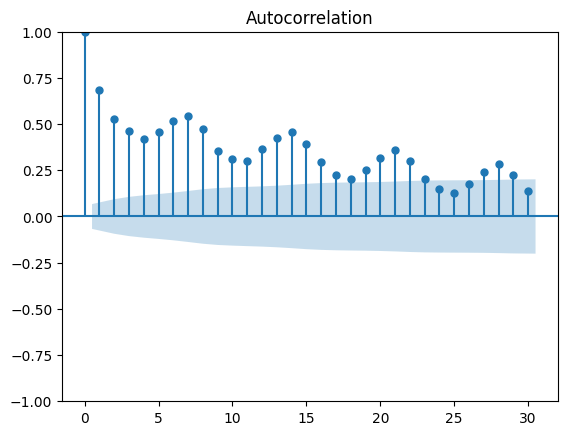

In [106]:
plot_acf(df['Users']);

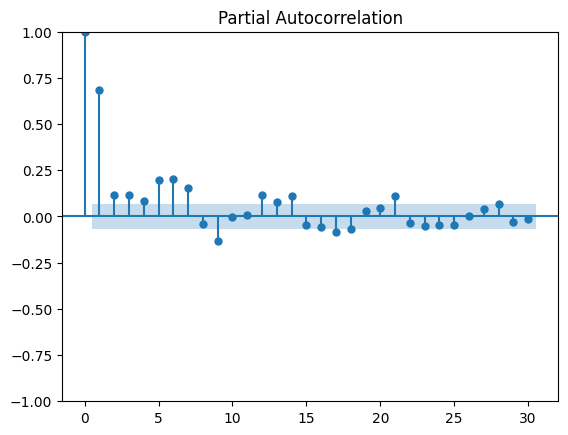

In [107]:
plot_pacf(df['Users']);

In [108]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

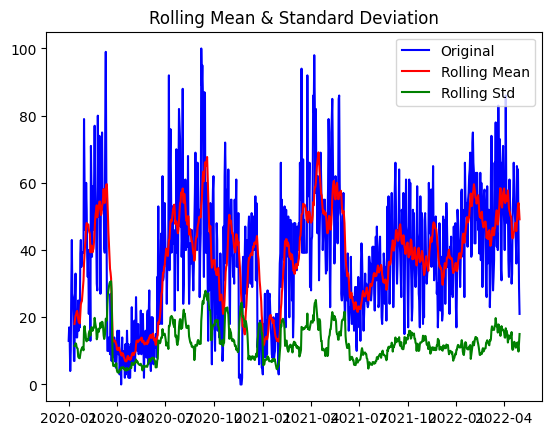

Results of Dickey Fuller Test:
Test Statistic                  -3.326740
p-value                          0.013725
#Lags Used                      20.000000
Number of Observations Used    830.000000
Critical Value (1%)             -3.438253
Critical Value (5%)             -2.865029
Critical Value (10%)            -2.568628
dtype: float64


In [109]:
test_stationarity(df)

In [130]:
X = df['Users'].values
train = X[:int(len(X)*0.95)]
test = X[int(len(X)*0.95):]
print(len(X), len(train) + len(test))

851 851


In [131]:
len(test)

43

In [132]:
model_ar = best_arima(train, len(test), 1)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

9 5 0.18092969042169033


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [133]:
model = ARIMA(order=(9, 1, 5)) # 95% de data mape 0.18
model_ar = model.fit(train)

predictions = model_ar.predict(len(test))
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE: 8.80559702114663
MAPE: 0.18092969042169033


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


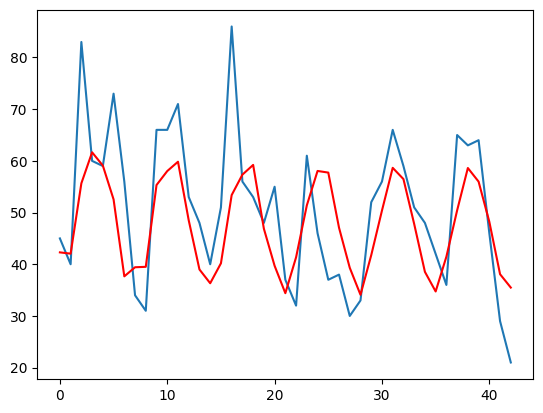

In [134]:
plt.plot(test)
plt.plot(predictions,color='red');

Logaritm scale

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


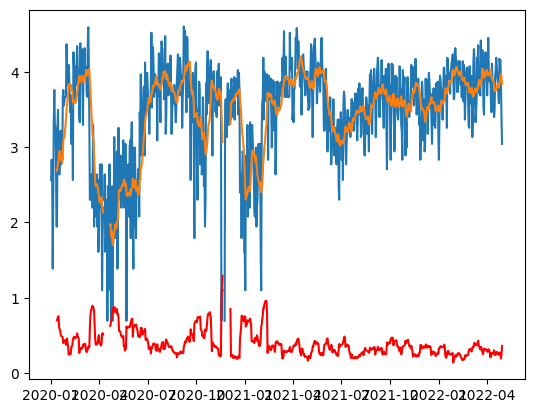

In [67]:
df_logScale = np.log(df)
plt.plot(df_logScale);
plt.plot(df_logScale.rolling(12).mean())
plt.plot(df_logScale.rolling(12).std(), color='r')

In [68]:
dfLogScaleMinusMovingAverage = df_logScale - df_logScale.rolling(12).mean()
dfLogScaleMinusMovingAverage.dropna(inplace=True)

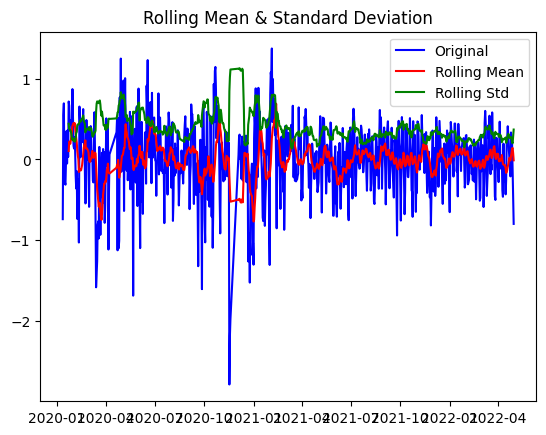

Results of Dickey Fuller Test:
Test Statistic                -5.799568e+00
p-value                        4.665177e-07
#Lags Used                     2.000000e+01
Number of Observations Used    7.930000e+02
Critical Value (1%)           -3.438623e+00
Critical Value (5%)           -2.865192e+00
Critical Value (10%)          -2.568714e+00
dtype: float64


In [69]:
test_stationarity(dfLogScaleMinusMovingAverage)

In [71]:
df_logScale[df_logScale.index.isin(np.isfinite(df_logScale[['Users']]).query('not Users').index)] = 0

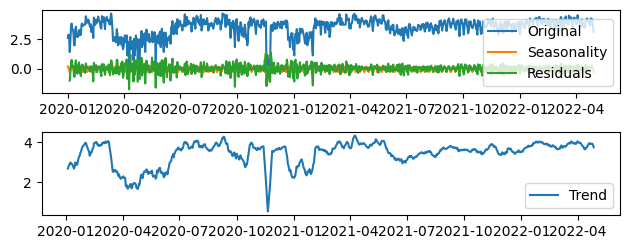

In [72]:
decomposition = seasonal_decompose(df_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

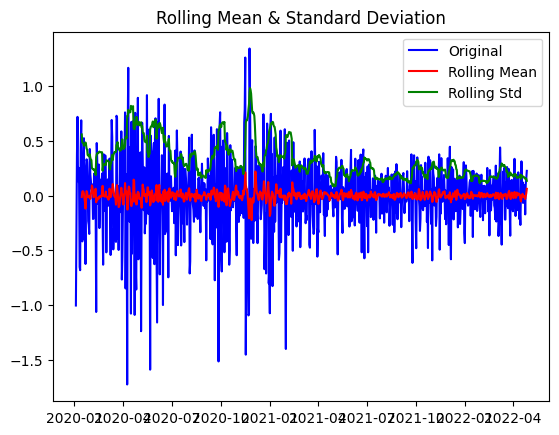

Results of Dickey Fuller Test:
Test Statistic                -1.288813e+01
p-value                        4.508296e-24
#Lags Used                     1.900000e+01
Number of Observations Used    8.250000e+02
Critical Value (1%)           -3.438301e+00
Critical Value (5%)           -2.865050e+00
Critical Value (10%)          -2.568639e+00
dtype: float64


In [73]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

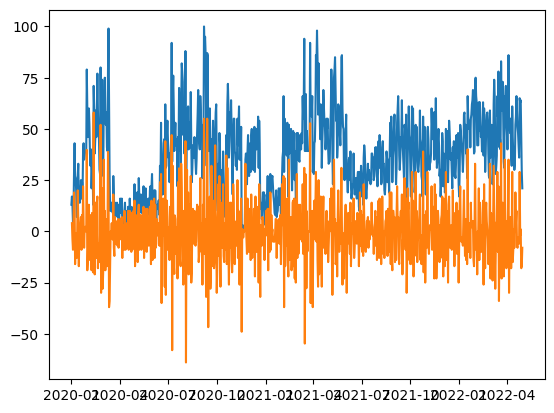

In [74]:
plt.plot(df)
plt.plot(df.diff())

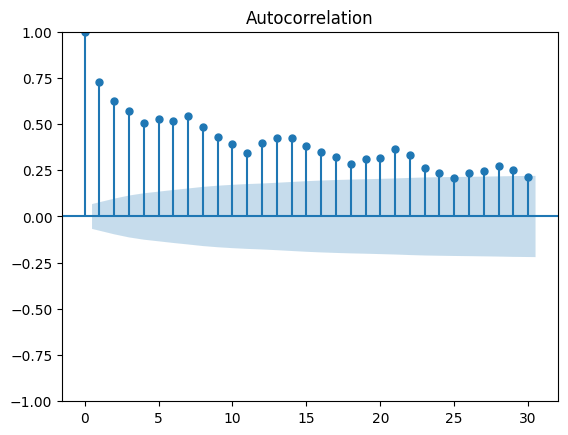

In [75]:
plot_acf(df_logScale['Users'].dropna()); # q = 7

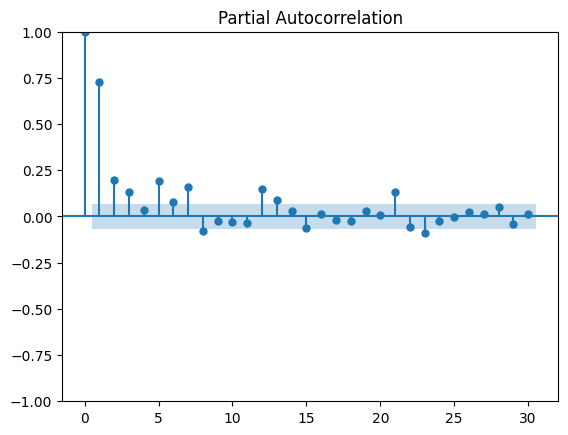

In [76]:
plot_pacf(df_logScale['Users'].dropna()); # p = 2

In [77]:
X = df_logScale['Users'].values
train = X[:int(len(X)*0.85)]
test = X[int(len(X)*0.85):]
print(len(X), len(train) + len(test))

851 851


In [78]:
len(test)

128

In [85]:
model_ar = ARIMA(order=(2, 1, 25))
model_ar.fit(train)

predictions = model_ar.predict(128)
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 0.2668770242666658
MAPE: 0.06965123805983614


In [86]:
model_ar = best_arima(train, 128, 1)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

In [88]:
model_ar

(9, 7, 0.05459828112284683)

In [92]:
model = ARIMA(order=(9, 1, 7))
model_ar.fit(train)

predictions = model_ar.predict(128)
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE: 0.20801418737397864
MAPE: 0.05459828112284683


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


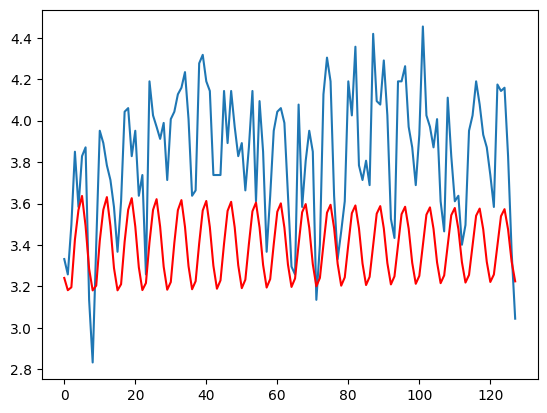

In [93]:
plt.plot(test)
plt.plot(predictions_log,color='red');

In [97]:
predictions_log = pd.DataFrame(data=predictions_log, index=df.iloc[int(len(X)*0.85):].index, columns=['Users'])
predictions = np.exp(predictions_log)
print(predictions)

                Users
Date                 
2021-12-24  25.560267
2021-12-25  24.094232
2021-12-26  24.431844
2021-12-27  30.752319
2021-12-28  35.492036
...               ...
2022-04-26  34.430429
2022-04-27  35.619758
2022-04-28  32.298838
2022-04-29  27.668273
2022-04-30  25.142475

[128 rows x 1 columns]


SMOOTHING

In [12]:
conn = sqlite3.connect('DB/daily_visits.db')
df = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date', index_col='Date')
conn.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851 entries, 2020-01-01 to 2022-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Users   851 non-null    int64
dtypes: int64(1)
memory usage: 13.3 KB


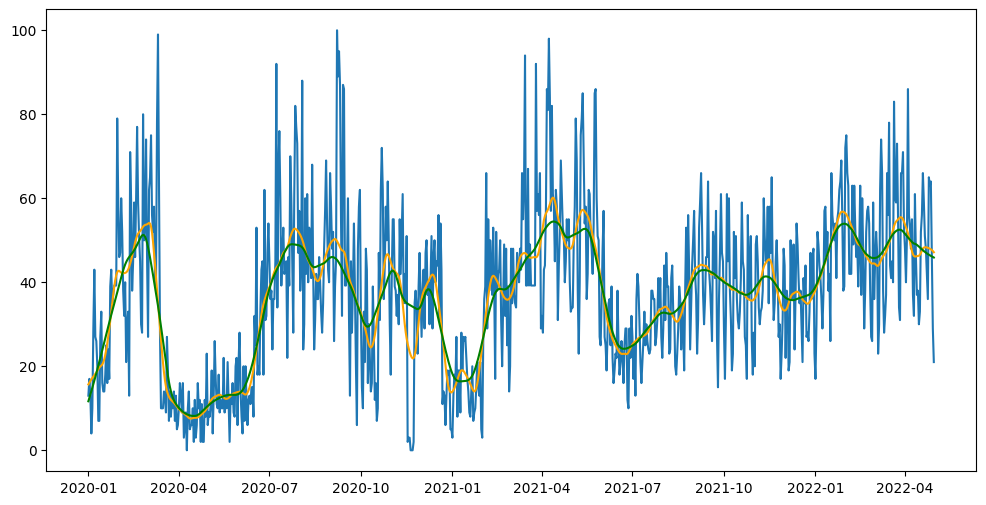

In [135]:
from statsmodels.nonparametric.smoothers_lowess import lowess

df_loess_3 = pd.DataFrame(lowess(df['Users'], np.arange(len(df['Users'])), frac=0.03)[:, 1], index=df.index, columns=['Users'])
df_loess_5 = pd.DataFrame(lowess(df['Users'], np.arange(len(df['Users'])), frac=0.05)[:, 1], index=df.index, columns=['Users'])

plt.figure(figsize=(12, 6))
plt.plot(df['Users'])
plt.plot(df_loess_3, color='orange')
plt.plot(df_loess_5, color='green')

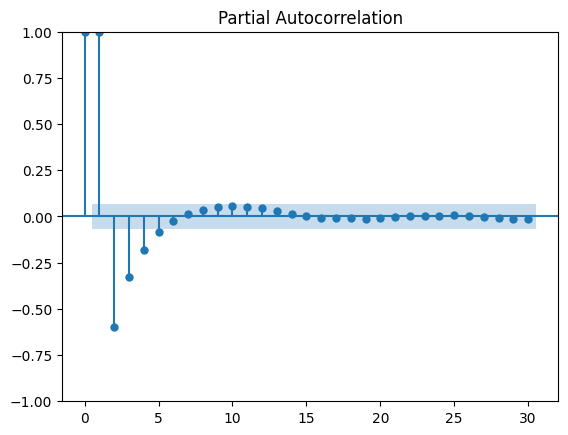

In [15]:
plot_pacf(df_loess_3['Users'].dropna());

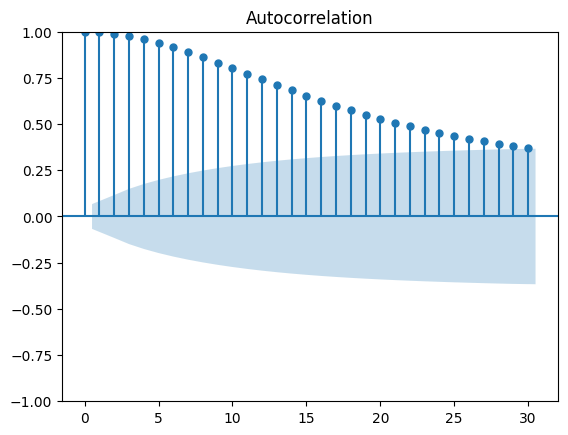

In [17]:
plot_acf(df_loess_3['Users'].dropna());

In [18]:
X = df_loess_3['Users'].values
train = X[:int(len(X)*0.85)]
test = X[int(len(X)*0.85):]
print(len(X), len(train) + len(test))

851 851


In [21]:
len(test)

128

In [19]:
model = auto_arima(train,
                   start_p = 5,
                   start_q = 5,
                   max_p = 15,
                   max_q = 15,
                   d = 1,
                   m=7,
                   trace=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(5,1,5)(1,0,1)[7] intercept   : AIC=-2262.453, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2168.787, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-145.578, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=830.804, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2167.222, Time=0.01 sec
 ARIMA(5,1,5)(0,0,1)[7] intercept   : AIC=-2270.494, Time=1.30 sec
 ARIMA(5,1,5)(0,0,0)[7] intercept   : AIC=-2228.631, Time=0.82 sec
 ARIMA(5,1,5)(0,0,2)[7] intercept   : AIC=-2269.169, Time=2.36 sec
 ARIMA(5,1,5)(1,0,0)[7] intercept   : AIC=-2260.898, Time=1.41 sec
 ARIMA(5,1,5)(1,0,2)[7] intercept   : AIC=-2266.077, Time=2.70 sec
 ARIMA(4,1,5)(0,0,1)[7] intercept   : AIC=-2271.002, Time=0.98 sec
 ARIMA(4,1,5)(0,0,0)[7] intercept   : AIC=-2270.447, Time=0.60 sec
 ARIMA(4,1,5)(1,0,1)[7] intercept   : AIC=-2268.608, Time=1.15 sec
 ARIMA(4,1,5)(0,0,2)[7] intercept   : AIC=-2270.737, Time=1.82 sec
 ARIMA(4,1,5)(1,0,0)[7] 

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE: 5.492711385881684
MAPE: 0.1080931286934628


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


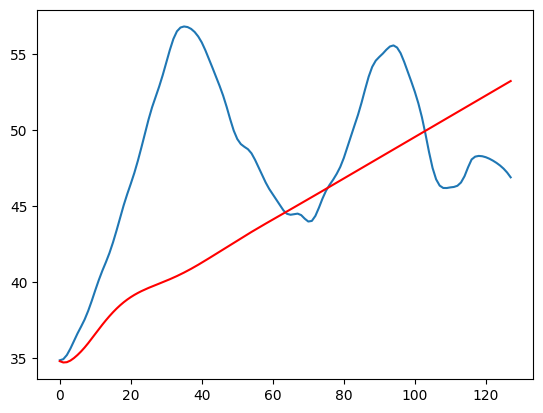

In [46]:
model = ARIMA(order=(7, 1, 5))
model_fit = model.fit(train)

predictions = model_fit.predict(128)
print("MAE:", mean_absolute_error(test, predictions))
print("MAPE:", mean_absolute_percentage_error(test, predictions))
plt.plot(test)
plt.plot(predictions,color='red');

PROBAR CON XGBoost
https://www.youtube.com/watch?v=vV12dGe_Fho

In [311]:
conn = sqlite3.connect('DB/daily_visits.db')
df2 = pd.read_sql("SELECT * FROM visit_quant", conn, parse_dates='Date')
conn.close()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    851 non-null    datetime64[ns]
 1   Users   851 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.4 KB


In [312]:
df2['Users'] = df2['Users'].apply(lambda x: max(x, 1))

<Axes: xlabel='Weekday'>

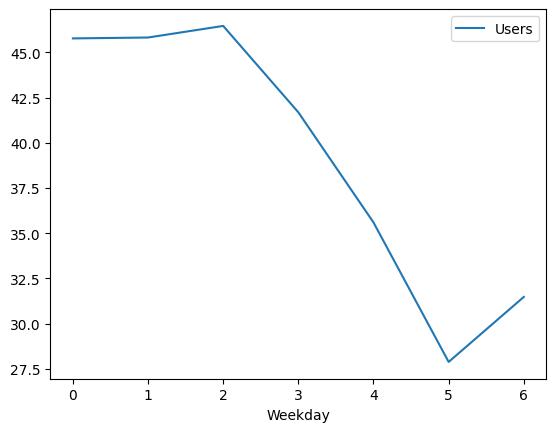

In [313]:
df2['Weekday'] = df2['Date'].dt.weekday
df2.groupby('Weekday')[['Users']].mean().plot() # jueves viernes y sabado hay menos visitas

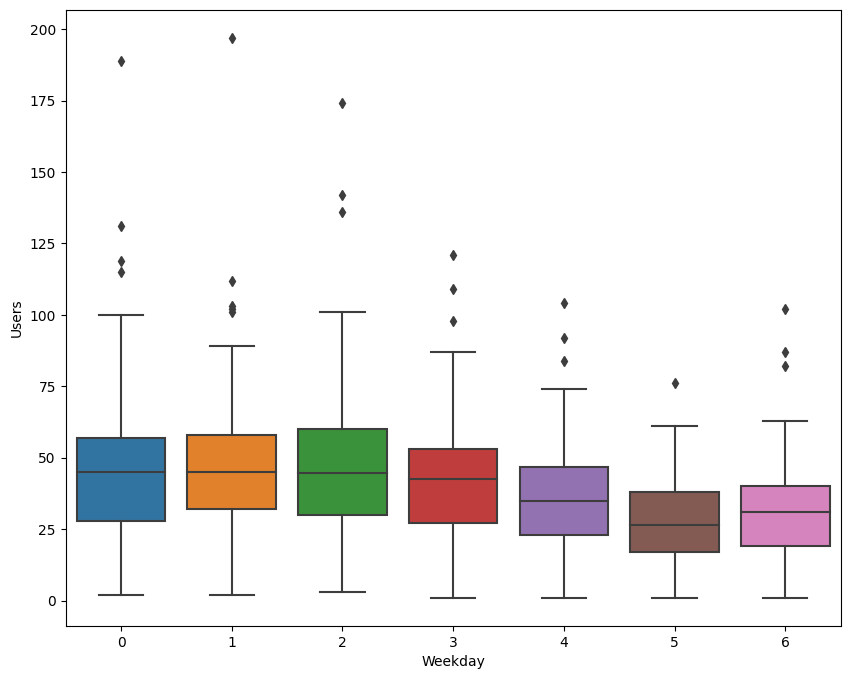

In [314]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='Weekday', y='Users')
plt.show()

<Axes: xlabel='Month'>

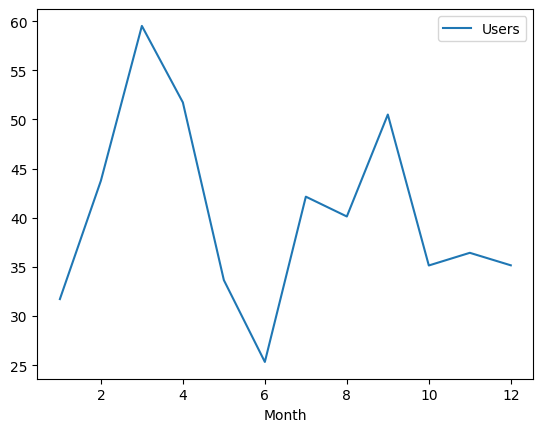

In [315]:
df2['Month'] = df2['Date'].dt.month
df2.iloc[122:].groupby('Month')[['Users']].mean().plot() # en verano y navidad hay menos

In [316]:
df2.groupby('Month')[['Date', 'Users']].mean()

,Date,Users
Month,,
1,2021-01-15 16:00:00.000000000,34.494624
2,2021-02-10 00:50:49.411764736,45.105882
3,2021-03-16 00:00:00.000000000,50.763441
4,2021-04-15 12:00:00.000000000,37.388889
5,2020-11-14 12:00:00.000000000,33.258065
6,2020-12-15 00:00:00.000000000,25.333333
7,2021-01-14 12:00:00.000000000,42.145161
8,2021-02-14 12:00:00.000000000,40.129032
9,2021-03-17 00:00:00.000000000,50.500000


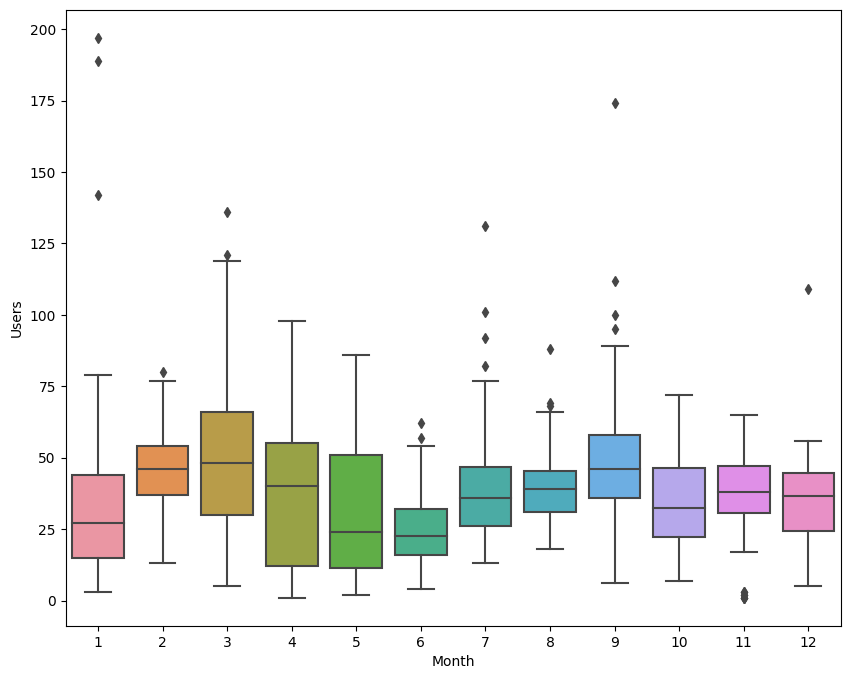

In [317]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='Month', y='Users')
plt.show()

<Axes: xlabel='Day'>

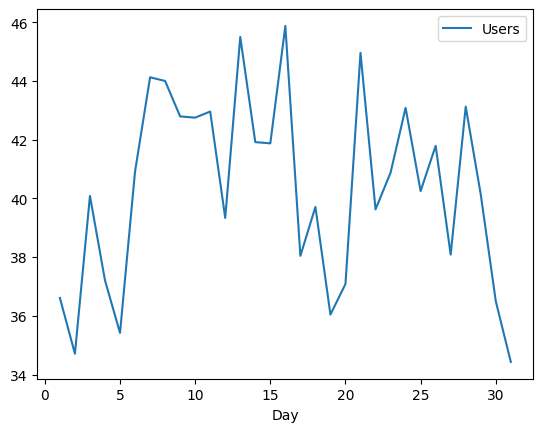

In [318]:
df2['Day'] = df2['Date'].dt.day
df2.iloc[122:].groupby('Day')[['Users']].mean().plot()

In [319]:
from sklearn.model_selection import train_test_split

X = df2[['Weekday', 'Month']] # .iloc[518:]
y = df2['Users']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

In [320]:
import xgboost as xgb

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[00:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:44.81636	validation_1-rmse:45.43135
[100]	validation_0-rmse:25.75652	validation_1-rmse:27.60145
[200]	validation_0-rmse:21.61244	validation_1-rmse:23.97841
[300]	validation_0-rmse:20.82036	validation_1-rmse:23.35972
[400]	validation_0-rmse:20.63192	validation_1-rmse:23.31049
[419]	validation_0-rmse:20.61503	validation_1-rmse:23.32054


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

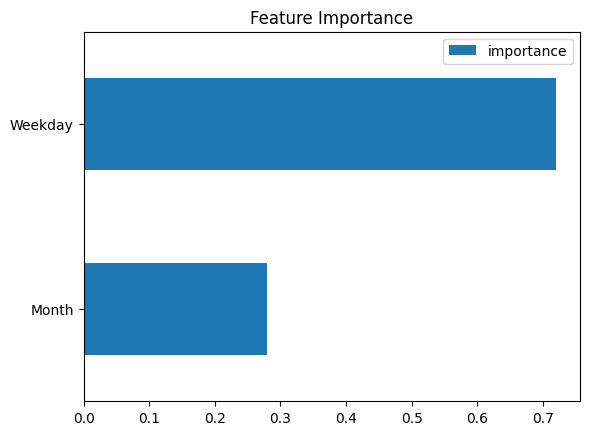

In [321]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [322]:
predictions = reg.predict(X_test)
print("MAE:", mean_absolute_error(y_test, predictions))
print("MAPE:", mean_absolute_percentage_error(y_test, predictions))

MAE: 15.456521575213873
MAPE: 1.3183548142040793


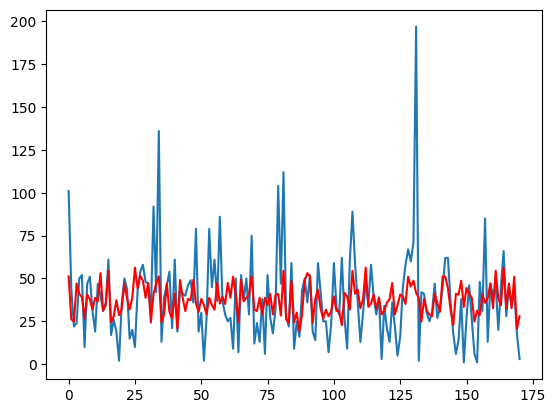

In [323]:
plt.plot(y_test.values)
plt.plot(predictions,color='red');

In [308]:
test = df2.iloc[518:]

In [309]:
ytest = test[int(len(test)*0.8):]
ytest.sort_values('Users', ascending=False)

,Date,Users,Weekday,Month,Day
824,2022-04-04,86,0,4,4
810,2022-03-21,83,0,3,21
805,2022-03-16,78,2,3,16
797,2022-03-08,74,1,3,8
813,2022-03-24,73,3,3,24
...,...,...,...,...,...
800,2022-03-11,28,4,3,11
787,2022-02-26,27,5,2,26
788,2022-02-27,26,6,2,27
794,2022-03-05,23,5,3,5
